## Try to maximize the likelihood (CMB parameterization)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=1)

Setup archive of P1D measurements from simulations to train the emulator

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [5]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_sim)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [6]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0","ln_kF_0"]
    like_param_limits=[[-0.2, 0.2],[-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [7]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5,
                            emu_cov_factor=1)

In [8]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
starting chi2 864.5492919680808


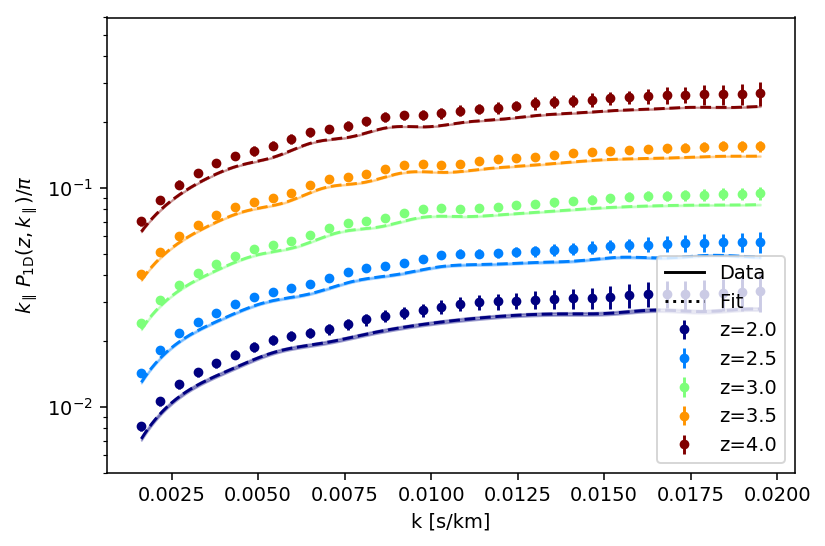

In [9]:
like.plot_p1d(plot_every_iz=2)

# Run minimiser

In [10]:
from scipy.optimize import minimize

In [11]:
def callbackF(xk):
    chi2=like.get_chi2(values=xk)
    print('chi2=',chi2,'at x=',xk)
    for par in like.parameters_from_sampling_point(xk):
        print(par.info_str())

In [12]:
results=minimize(like.minus_log_prob, x0=theta,method = 'Nelder-Mead',
                 options={'disp':True,'maxiter':1000},callback=callbackF)

chi2= 634.1000815760372 at x= [0.5   0.525 0.5   0.5   0.5   0.5  ]
As = 1.9999999999999997e-09
ns = 0.97875
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
chi2= 493.60623082537103 at x= [0.51666667 0.51666667 0.51666667 0.51666667 0.4875     0.51666667]
As = 2.0333333333333333e-09
ns = 0.9775
ln_tau_0 = 0.006666666666666654
ln_sigT_kms_0 = 0.006666666666666654
ln_gamma_0 = -0.004999999999999977
ln_kF_0 = 0.006666666666666654
chi2= 493.60623082537103 at x= [0.51666667 0.51666667 0.51666667 0.51666667 0.4875     0.51666667]
As = 2.0333333333333333e-09
ns = 0.9775
ln_tau_0 = 0.006666666666666654
ln_sigT_kms_0 = 0.006666666666666654
ln_gamma_0 = -0.004999999999999977
ln_kF_0 = 0.006666666666666654
chi2= 237.1714119288519 at x= [0.53333333 0.53333333 0.53333333 0.50416667 0.475      0.47083333]
As = 2.066666666666666e-09
ns = 0.98
ln_tau_0 = 0.01333333333333328
ln_sigT_kms_0 = 0.0016666666666666496
ln_gamma_0 = -0.009999999999999953
ln_kF_0 = -0.011666666666666714
chi2= 

In [13]:
print('maximum posterior =',-results.fun)
callbackF(results.x)

maximum posterior = -35.800135983917286
chi2= 4.565523267520596 at x= [0.33929262 0.44326646 0.7560804  0.276985   0.23412335 0.47228615]
As = 1.678585234336049e-09
ns = 0.9664899689829101
ln_tau_0 = 0.10243215904599956
ln_sigT_kms_0 = -0.08920600079537833
ln_gamma_0 = -0.10635066111627013
ln_kF_0 = -0.011085540015328854


In [14]:
# compare to truth
sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 1.765434e-09
true ns = 0.965899


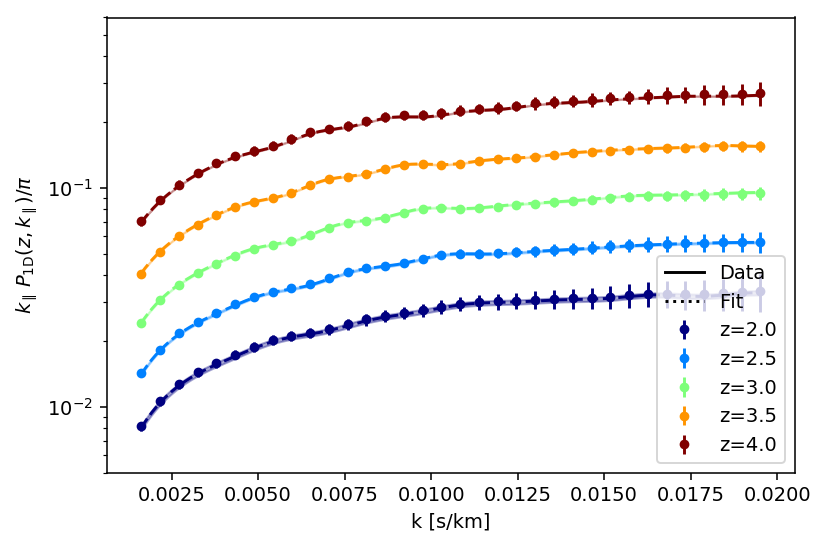

In [15]:
like.plot_p1d(plot_every_iz=2,values=results.x)